<a href="https://colab.research.google.com/github/utamiu1807/uutami/blob/main/Final_EDA1%262_UTAMIipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Research question:
1. Did imports to the U.S. change significantly under the Trump tariff war,  and which countries were most affected?
2. analysis on the changes between 20 top countries.

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import requests
import re

warnings.filterwarnings("ignore")

files = [
    'https://raw.githubusercontent.com/utamiu1807/uutami/main/impor_2023_yearly_hts2.xlsx',
    'https://raw.githubusercontent.com/utamiu1807/uutami/main/impor_2023_yearly_hts4.xlsx',
    'https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%202024_HTS_2.xlsx',
    'https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%202024_HTS_4.xlsx',
    'https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%20AUG-2025-HTS4_2.xlsx',
    'https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%20AUG_2025_HTS_4.xlsx'
]

all_data = []

# Combine all dataframes if successful
for a in files:
    try:
        xls = pd.ExcelFile(a)
        sheet = [s for s in xls.sheet_names if "CIF" in s][0]
        df = pd.read_excel(xls, sheet_name=sheet, usecols="A:E").iloc[:-1]

        # Clean columns
        df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

     # Add year if missing
        if 'year' not in df.columns:
            if '2023' in a: df['year'] = 2023
            elif '2024' in a: df['year'] = 2024
            elif '2025' in a: df['year'] = 2025

        df['Source_File'] = a.split('/')[-1]
        all_data.append(df)
        print(f" successfully loaded: {a}")
    except Exception as e:
        print(f"Error loading {a}: {e}")

# Combine all
final_df = pd.concat(all_data, ignore_index=True)
print(final_df['year'].value_counts())
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    display(final_df.head(5))


 successfully loaded: https://raw.githubusercontent.com/utamiu1807/uutami/main/impor_2023_yearly_hts2.xlsx
 successfully loaded: https://raw.githubusercontent.com/utamiu1807/uutami/main/impor_2023_yearly_hts4.xlsx
 successfully loaded: https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%202024_HTS_2.xlsx
 successfully loaded: https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%202024_HTS_4.xlsx
 successfully loaded: https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%20AUG-2025-HTS4_2.xlsx
 successfully loaded: https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%20AUG_2025_HTS_4.xlsx
year
2024    71129
2023    71098
2025    64220
Name: count, dtype: int64


,data_type,country,hts_number,description,cif_import_value,year,Source_File,january_2024_to_december_2024,january_2025_to_august_2025
0,CIF Import Value,Afghanistan,7.0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS,215132,2023,impor_2023_yearly_hts2.xlsx,NaN,NaN
1,CIF Import Value,Afghanistan,15.0,ANIMAL OR VEGETABLE FATS AND OILS AND THEIR CL...,43836,2023,impor_2023_yearly_hts2.xlsx,NaN,NaN
2,CIF Import Value,Afghanistan,49.0,"PRINTED BOOKS, NEWSPAPERS, PICTURES AND OTHER ...",2992,2023,impor_2023_yearly_hts2.xlsx,NaN,NaN
3,CIF Import Value,Afghanistan,83.0,MISCELLANEOUS ARTICLES OF BASE METAL,9458,2023,impor_2023_yearly_hts2.xlsx,NaN,NaN
4,CIF Import Value,Afghanistan,94.0,"FURNITURE; BEDDING, CUSHIONS ETC.; LAMPS AND L...",6570,2023,impor_2023_yearly_hts2.xlsx,NaN,NaN


In [ ]:
for a, df in zip(files, all_data):
    print(f"{a} → rows: {len(df)}")


https://raw.githubusercontent.com/utamiu1807/uutami/main/impor_2023_yearly_hts2.xlsx → rows: 11204
https://raw.githubusercontent.com/utamiu1807/uutami/main/impor_2023_yearly_hts4.xlsx → rows: 59894
https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%202024_HTS_2.xlsx → rows: 11225
https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%202024_HTS_4.xlsx → rows: 59904
https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%20AUG-2025-HTS4_2.xlsx → rows: 10242
https://raw.githubusercontent.com/utamiu1807/uutami/main/IMPORT%20AUG_2025_HTS_4.xlsx → rows: 53978


In [ ]:
#combine all datasets
merged_df = pd.concat(all_data, ignore_index=True)


#DATA CLEANING
df = merged_df.rename(columns={
    "Country": "country",
    "HTS Number": "HTS",
    "Description": "Description",
    "cif_import_value": "import_2023",
    "january_2024_to_december_2024": "import_2024",
    "january_2025_to_august_2025": "import_2025"
})


#convert import value to numeric type
for col in ["import_2023","import_2024", "import_2025"]:
  df[col] = pd.to_numeric(df[col], errors="coerce")

# Clean and convert HTS numbers to text (no decimals)
df['hts_number'] = (final_df['hts_number'].astype(str).str.replace(r'\.0+$', '', regex=True))

#convert country to text
for col in ["country"]:df[col] = df[col].astype(str)

#check if any na in country
df.country.isna().sum()
df= df.dropna(subset=["import_2023", "import_2024", "import_2025"], how="all")

# Reshape into long format
df_long = df.melt(
    id_vars=["country", "hts_number", "description", "Source_File"],
    value_vars=["import_2023","import_2024", "import_2025"],
    var_name="Year",
    value_name="CIF_Value"
)

# Extract year number
df_long["Year"] = df_long["Year"].str.extract(r"(\d{4})").astype(int)

# Drop missing/zero values
df_long = df_long.dropna(subset=["CIF_Value"])
df_long = df_long[df_long["CIF_Value"] > 0]

print(df_long.shape)
df_clean = df_long.copy()
display(df_clean)

(205918, 6)


,country,hts_number,description,Source_File,Year,CIF_Value
0,Afghanistan,7,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS,impor_2023_yearly_hts2.xlsx,2023,215132.0
1,Afghanistan,15,ANIMAL OR VEGETABLE FATS AND OILS AND THEIR CL...,impor_2023_yearly_hts2.xlsx,2023,43836.0
2,Afghanistan,49,"PRINTED BOOKS, NEWSPAPERS, PICTURES AND OTHER ...",impor_2023_yearly_hts2.xlsx,2023,2992.0
3,Afghanistan,83,MISCELLANEOUS ARTICLES OF BASE METAL,impor_2023_yearly_hts2.xlsx,2023,9458.0
4,Afghanistan,94,"FURNITURE; BEDDING, CUSHIONS ETC.; LAMPS AND L...",impor_2023_yearly_hts2.xlsx,2023,6570.0
...,...,...,...,...,...,...
619336,Zimbabwe,7116,"ARTICLES OF NATURAL OR CULTURED PEARLS, PRECIO...",IMPORT%20AUG_2025_HTS_4.xlsx,2025,18983.0
619337,Zimbabwe,511,ANIMAL PRODUCTS NESOI; DEAD ANIMALS (OF CHAPTE...,IMPORT%20AUG_2025_HTS_4.xlsx,2025,109927.0
619338,Zimbabwe,6810,"ARTICLES OF CEMENT, CONCRETE OR ARTIFICIAL STO...",IMPORT%20AUG_2025_HTS_4.xlsx,2025,26733.0
619339,Zimbabwe,6205,"MEN'S OR BOYS' SHIRTS, NOT KNITTED OR CROCHETED",IMPORT%20AUG_2025_HTS_4.xlsx,2025,21818.0


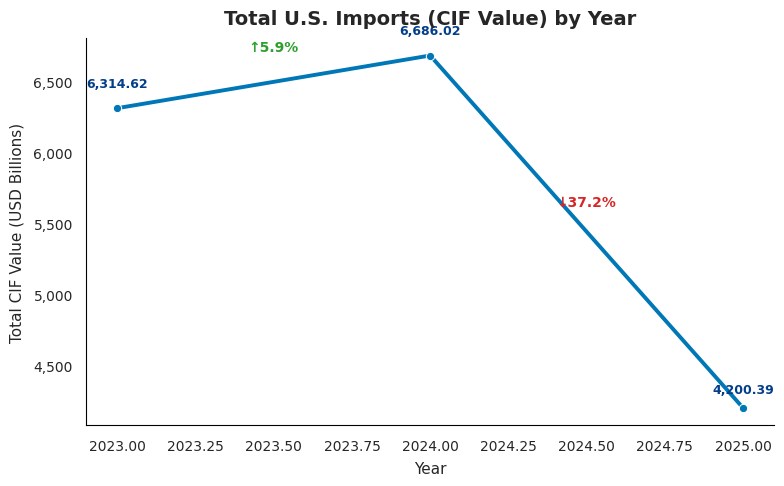

In [ ]:
#2.EXPLORATORY DATA ANALYSIS
# Total imports by year
total_by_year = df_clean.groupby("Year")["CIF_Value"].sum().reset_index()

# Convert to billions if large
if total_by_year["CIF_Value"].max() > 1e9:
    total_by_year["CIF_Value_B"] = total_by_year["CIF_Value"] / 1e9
    y_col = "CIF_Value_B"
    y_label = "Total CIF Value (USD Billions)"
else:
    y_col = "CIF_Value"
    y_label = "Total CIF Value (USD Millions)"

# Compute year-over-year percent change
total_by_year["pct_change"] = total_by_year[y_col].pct_change() * 100

# Visualization
sns.set_style("white")  # remove grid background
plt.rcParams.update({
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.grid": False,
    "font.size": 11,
    "axes.titleweight": "bold"
})

fig, ax = plt.subplots(figsize=(8, 5))

# Smooth line with markers
sns.lineplot(
    data=total_by_year,
    x="Year", y=y_col,
    marker="o", linewidth=2.8,
    color="#0077b6", ax=ax
)

# Add numeric value labels above each point
for i, row in total_by_year.iterrows():
    ax.text(
        row["Year"], row[y_col] * 1.02,
        f"{row[y_col]:,.2f}",
        ha="center", va="bottom",
        fontsize=9, fontweight="bold", color="#023e8a"
    )

# Add % change annotations between points
for i in range(1, len(total_by_year)):
    prev_x = total_by_year["Year"].iloc[i-1]
    prev_y = total_by_year[y_col].iloc[i-1]
    curr_x = total_by_year["Year"].iloc[i]
    curr_y = total_by_year[y_col].iloc[i]
    change = total_by_year["pct_change"].iloc[i]

    color = "#2ca02c" if change > 0 else "#d62728"
    arrow = "↑" if change > 0 else "↓"

    # Position label slightly above midpoint
    mid_x = (prev_x + curr_x) / 2
    mid_y = (prev_y + curr_y) / 2 * 1.03

    ax.text(
        mid_x, mid_y,
        f"{arrow}{abs(change):.1f}%",
        color=color, fontsize=10, ha="center",
        va="bottom", weight="bold"
    )

ax.set_title("Total U.S. Imports (CIF Value) by Year", fontsize=14, weight="bold", pad=10)
ax.set_xlabel("Year", fontsize=11, labelpad=6)
ax.set_ylabel(y_label, fontsize=11, labelpad=6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.8)
ax.spines["bottom"].set_linewidth(0.8)
ax.tick_params(axis="both", labelsize=10)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))

# Remove all background and fill
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

plt.tight_layout()
plt.show()



Number of unique countries: 232


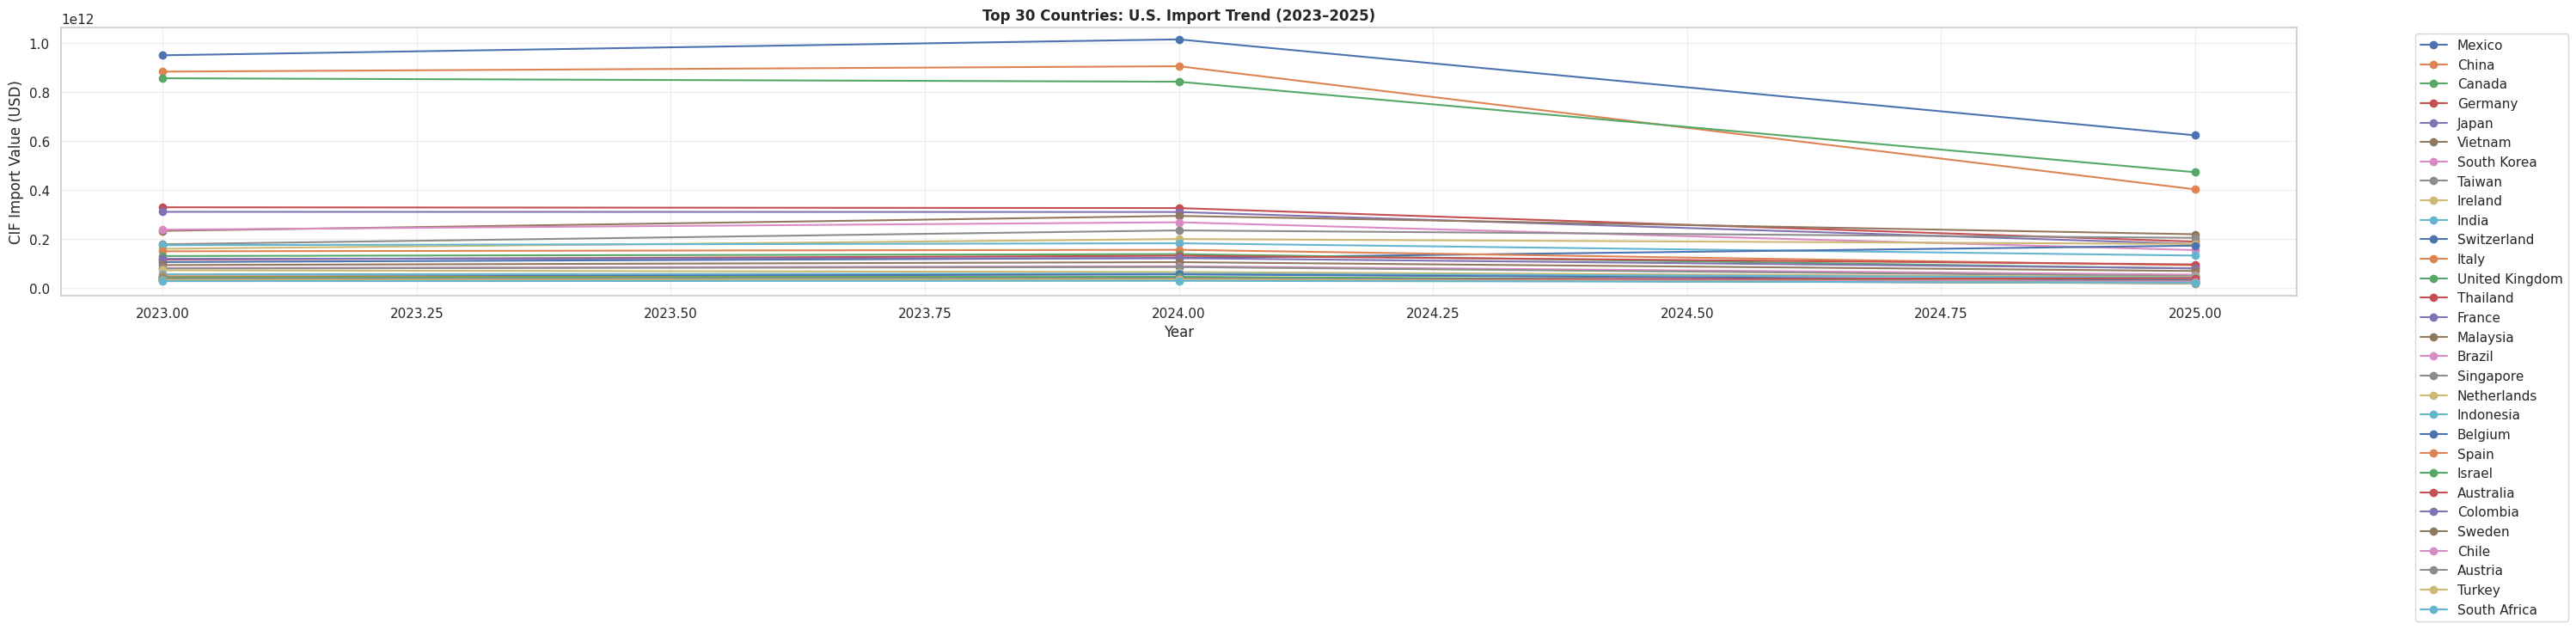

<Figure size 640x480 with 0 Axes>

In [ ]:
#ANALYSIS ON COUNTRIES BY import value
#analysis on 30 largest country
number_of_countries = df_clean["country"].nunique()
print(f"Number of unique countries: {number_of_countries}")
top_countries = (df_clean.groupby("country")["CIF_Value"].sum().nlargest(30).index)

trend_top = df_clean[df_clean["country"].isin(top_countries)]
trend_summary = trend_top.groupby(["Year", "country"])["CIF_Value"].sum().reset_index()

plt.figure(figsize=(30,6))
for country in top_countries:
    subset = trend_summary[trend_summary["country"] == country]
    plt.plot(subset["Year"], subset["CIF_Value"], marker="o", label=country)

plt.title("Top 30 Countries: U.S. Import Trend (2023–2025)")
plt.xlabel("Year")
plt.ylabel("CIF Import Value (USD)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()
plt.savefig("Top 30 Countries: U.S. Import Trend (2023–2025).png", dpi=300, bbox_inches="tight")

OBJECTIVE 2: ANALYSIS ON TOP 20 COUNTRIES



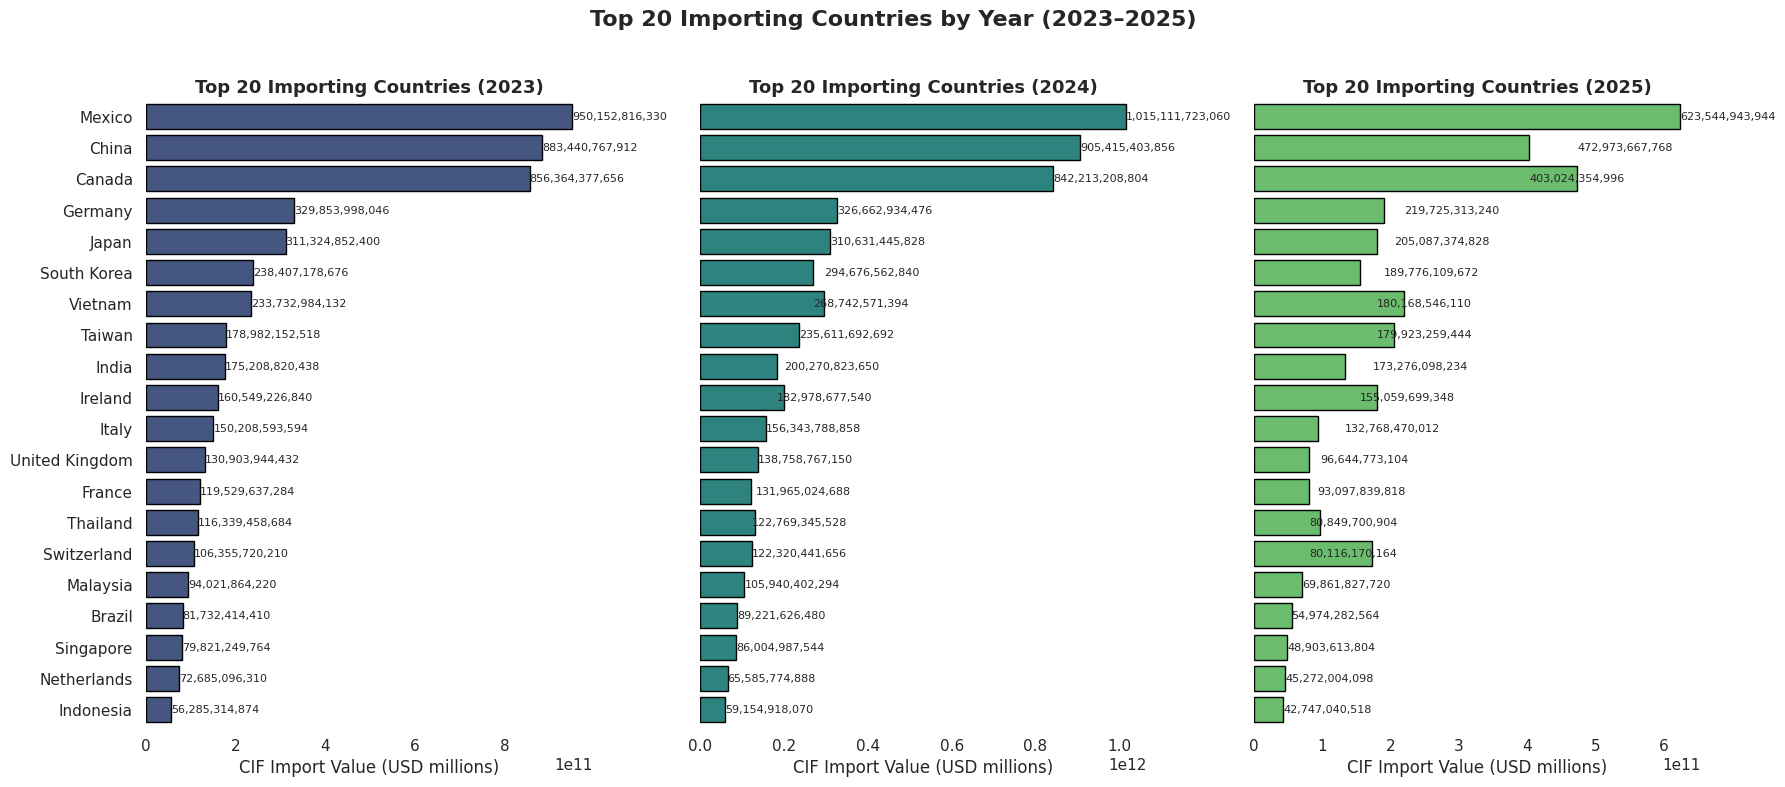

<Figure size 640x480 with 0 Axes>

In [ ]:
#EDA.3 Analysis the changes between 20 top countries.
# Aggregate total imports by country and year
country_year_totals = (df_clean.groupby(["Year", "country"])["CIF_Value"].sum().reset_index())

top_2023 = country_year_totals[country_year_totals["Year"] == 2023].nlargest(20, "CIF_Value")
top_2024 = country_year_totals[country_year_totals["Year"] == 2024].nlargest(20, "CIF_Value")
top_2025 = country_year_totals[country_year_totals["Year"] == 2025].nlargest(20, "CIF_Value")

# Visualization
sns.set_style("white")
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.edgecolor"] = "black"

# Color palette for the three years
palette = sns.color_palette("viridis", 3)

# Prepare figure
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

# Helper function for uniform plotting
def plot_top(ax, data, year, color):
    data = data.sort_values("CIF_Value", ascending=True)

    sns.barplot(data=data,
        y="country", x="CIF_Value",
        ax=ax, color=color, edgecolor="black", legend=False)

    # Clean formatting
    ax.set_title(f"Top 20 Importing Countries ({year})", fontsize=13, weight="bold")
    ax.set_xlabel("CIF Import Value (USD millions)")
    ax.set_ylabel("")

    # Remove grid, spines, and background
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_facecolor("white")

    # Keep biggest at top
    ax.invert_yaxis()

    # Add value labels
    for i, v in enumerate(data["CIF_Value"]):
        ax.text(v, i, f"{v:,.0f}", va="center", ha="left", fontsize=8)

# Plot each year
plot_top(axes[0], top_2023, 2023, palette[0])
plot_top(axes[1], top_2024, 2024, palette[1])
plot_top(axes[2], top_2025, 2025, palette[2])

# Global formatting
fig.suptitle("Top 20 Importing Countries by Year (2023–2025)", fontsize=16, weight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
plt.savefig("Top 20 Importing Countries by Year (2023–2025).png", dpi=300, bbox_inches="tight")

In [ ]:
print(f"""Findings eda1:
1. 2023 to 2024, there is 5.9% increase (for hts number 2 and 4). For 2025, we cannot conclude the trend because we only have data until August 2025.
2. There are 232 countries. when it is being ranked by import value, for the top 25 countries, the graph showed stabil graph. The concentration of trade among leading partners remained consistent year-over-year. There is quite gap between the 3 leading countries and other countries.
""")

Findings eda1:
1. 2023 to 2024, there is 5.9% increase (for hts number 2 and 4). For 2025, we cannot conclude the trend because we only have data until August 2025.
2. There are 232 countries. when it is being ranked by import value, for the top 25 countries, the graph showed stabil graph. The concentration of trade among leading partners remained consistent year-over-year. There is quite gap between the 3 leading countries and other countries.



In [ ]:
# Create Country-level CIF dataset with Percent Change (2024→2025)
df_country = df_clean.groupby(["country", "Year"])["CIF_Value"].sum().reset_index()
df_country = df_country.pivot(index="country", columns="Year", values="CIF_Value").fillna(0)

if 2023 in df_country.columns and 2024 in df_country.columns:
    df_country["Pct_Change_2023_2024"] = ((df_country[2024] - df_country[2023])
        / df_country[2023].replace(0, pd.NA)) * 100

if 2024 in df_country.columns and 2025 in df_country.columns:
    df_country["Pct_Change_2024_2025"] = ((df_country[2025] - df_country[2024])
        / df_country[2024].replace(0, pd.NA)) * 100
else:
    print("⚠️ Ensure your dataset includes both 2024 and 2025 year columns.")
#round up to 4 decimal
df_country = df_country.round(4)

country_df = df_country.reset_index()
country_df.to_excel("Country_CIF_with_PctChange.xlsx", index=False)
print(country_df.head(10))


Year              country          2023          2024          2025  \
0             Afghanistan  4.194321e+07  4.812620e+07  5.054457e+07   
1                 Albania  1.632641e+08  2.669765e+08  1.090784e+08   
2                 Algeria  6.444037e+09  5.601107e+09  3.004959e+09   
3                 Andorra  1.071761e+08  6.902600e+06  1.036573e+07   
4                  Angola  2.421862e+09  3.404982e+09  1.354762e+09   
5                Anguilla  2.751380e+06  2.594610e+06  1.407582e+06   
6     Antigua and Barbuda  2.426091e+07  4.501161e+07  1.882531e+07   
7               Argentina  1.451505e+10  1.621423e+10  9.814398e+09   
8                 Armenia  2.592036e+08  2.713828e+08  9.071519e+07   
9                   Aruba  3.018452e+07  2.163742e+07  8.212380e+06   

Year  Pct_Change_2023_2024  Pct_Change_2024_2025  
0                  14.7413                5.0251  
1                  63.5244              -59.1431  
2                 -13.0808              -46.3506  
3             

Adding new information about new tariff from Trump and whether the countries made deal with Trump or not.

In [ ]:
#webscraping
from bs4 import BeautifulSoup

# Scrape Steptoe Reciprocal Tariffs
def scrape_steptoe_tariffs(url):
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text, "html.parser")
    text = soup.get_text("\n", strip=True)
    start = text.find("Countries and Territories")
    end = text.find("*Throughout July")
    section = text[start:end]
    lines = [l.strip() for l in section.split("\n") if l.strip()]
    data = []
    for i in range(0, len(lines) - 1):
        if "%" in lines[i + 1] and not lines[i].endswith("%"):
            country = lines[i].replace("*", "").strip()
            rate = lines[i + 1].replace("%", "").strip()
            try:
                data.append((country, float(rate)))
            except:
                pass
    return pd.DataFrame(data, columns=["country", "Reciprocal_Tariff"])

steptoe_url = "https://www.steptoe.com/en/news-publications/global-trade-and-investment-law-blog/country-specific-reciprocal-tariffs-take-effect.html"
df_tariff = scrape_steptoe_tariffs(steptoe_url)

# List of Countries made Deal to Trump and Countries Not-Hit by reciprocal tariff
deal_list = [
    "United Kingdom", "European Union", "Japan", "Korea",
    "Vietnam", "Malaysia", "Indonesia", "Philippines",
    "Thailand", "Cambodia", "Pakistan", "Mexico", "Canada"
]

not_hit_list = [
    "Australia", "New Zealand",
    "Singapore", "Switzerland"
]  # From Newsweek "not hit" list

merged = country_df.merge(df_tariff, how="left", on="country")
merged["Reciprocal_Tariff"] = merged["Reciprocal_Tariff"].fillna(10)

merged["Not_Hit"] = merged["country"].apply(
    lambda x: 1 if any(x.lower() == nh.lower() for nh in not_hit_list) else 0)
merged["Trump_Deal"] = merged["country"].apply(
    lambda x: 1 if any(dl.lower() in x.lower() for dl in deal_list) else 0)

# If not hit → tariff = 0
merged.loc[merged["Not_Hit"] == 1, "Reciprocal_Tariff"] = 0
merged = merged.sort_values("Pct_Change_2024_2025", ascending=False)
merged.to_excel("Country_CIF_Tariff_PctChange_2023_2025.xlsx", index=False)

print("✅ Final dataset created: Country_CIF_Tariff_PctChange_2023_2025.xlsx")
print(merged.head(10))



✅ Final dataset created: Country_CIF_Tariff_PctChange_2023_2025.xlsx
                              country          2023          2024  \
222                        Uzbekistan  1.943999e+08  8.882368e+07   
54   Democratic Republic of the Congo  5.593803e+08  6.546637e+08   
214                      Turkmenistan  3.470410e+06  3.148347e+07   
112                              Laos  6.006315e+08  1.704966e+09   
227                 Wallis and Futuna  8.670600e+04  8.380800e+04   
81                          Gibraltar  1.841908e+06  8.707340e+05   
168             Republic of the Congo  6.560828e+08  1.129427e+08   
3                             Andorra  1.071761e+08  6.902600e+06   
106                        Kazakhstan  4.678285e+09  4.875878e+09   
200                       Switzerland  1.063557e+11  1.227693e+11   

             2025  Pct_Change_2023_2024  Pct_Change_2024_2025  \
222  1.094088e+09              -54.3088             1131.7528   
54   2.588390e+09               17.0337  

In [ ]:
#REGRESSION ANALYSIS: Impact of Tariffs and Deals on CIF Import Growth

import statsmodels.api as sm

# using merged df data
df = merged
df = df.dropna(subset=["Pct_Change_2023_2024", "Pct_Change_2024_2025"])

# tariff only start in 2025, just analysis Regression: 2024 → 2025
X2 = df[["Reciprocal_Tariff", "Trump_Deal", "Not_Hit"]]
y2 = df["Pct_Change_2024_2025"]
X2 = sm.add_constant(X2)

model2 = sm.OLS(y2, X2).fit()
print("\n===========================================================")
print("📈 Regression Results: CIF Import Growth 2024 → 2025")
print(model2.summary())



📈 Regression Results: CIF Import Growth 2024 → 2025
                             OLS Regression Results                             
Dep. Variable:     Pct_Change_2024_2025   R-squared:                       0.003
Model:                              OLS   Adj. R-squared:                 -0.010
Method:                   Least Squares   F-statistic:                    0.2272
Date:                  Mon, 13 Oct 2025   Prob (F-statistic):              0.877
Time:                          03:50:08   Log-Likelihood:                -1362.9
No. Observations:                   232   AIC:                             2734.
Df Residuals:                       228   BIC:                             2748.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [ ]:
# Regression Interpretation + Quarto Report Generator

import statsmodels.api as sm
from textwrap import dedent
df = merged
df = df.dropna(subset=["Pct_Change_2023_2024", "Pct_Change_2024_2025"])

# Run regressions
X_vars = ["Reciprocal_Tariff", "Trump_Deal", "Not_Hit"]

# Model 1: 2023 → 2024
X1 = sm.add_constant(df[X_vars])
y1 = df["Pct_Change_2023_2024"]
model1 = sm.OLS(y1, X1).fit()

# Model 2: 2024 → 2025
X2 = sm.add_constant(df[X_vars])
y2 = df["Pct_Change_2024_2025"]
model2 = sm.OLS(y2, X2).fit()

# Interpretation Function
def interpret_model(model, label):
    r2 = model.rsquared
    summary_lines = []
    for var, coef, pval in zip(model.params.index, model.params, model.pvalues):
        if var == "const":
            continue
        significance = "significant" if pval < 0.05 else "not significant"
        direction = "positive" if coef > 0 else "negative"
        summary_lines.append(
            f"- **{var}**: {direction} effect ({coef:.2f}), p={pval:.3f} → {significance}."
        )

    interpretation = dedent(f"""
    ## Regression Results: {label}

    - **R² = {r2:.3f}** → The model explains about {r2*100:.1f}% of the variation in CIF import growth.
    {' '.join(summary_lines)}

    **Interpretation:**
    In this period, there was {('some' if r2>0.2 else 'no clear')} statistical relationship
    between tariffs, deals, or exemptions and CIF import growth. Tariff levels and deal status
    likely had minimal influence compared to broader global economic factors.
    """)
    return interpretation


# ------------------------------------------
# 4️⃣ Generate Interpretation Text
text_1 = interpret_model(model1, "CIF Import Growth 2023 → 2024")
text_2 = interpret_model(model2, "CIF Import Growth 2024 → 2025")

report_text = f"""
# CIF Import Regression Summary Report

This report analyzes whether **Reciprocal Tariffs**, **Trump Deals**, and **Not-Hit status**
significantly explain changes in CIF import values across countries from 2023–2025.

---

{text_1}

---

{text_2}

---

### Overall Summary

Across both periods, the regression models show **very low explanatory power** (R² ≈ 0),
indicating that these trade-policy indicators did not meaningfully predict changes in CIF import value.
Macroeconomic conditions, sectoral shocks, and global trade trends likely played a much larger role.
"""

# ------------------------------------------
# 5️⃣ Save text for Quarto
# ------------------------------------------
with open("report.qmd", "w", encoding="utf-8") as f:
    f.write(report_text)

print("✅ Quarto report.qmd created successfully.")


✅ Quarto report.qmd created successfully.


Columns after cleaning and conversion: ['country', 2023, 2024, 2025, 'Pct_Change_2023_2024', 'Pct_Change_2024_2025', 'Reciprocal_Tariff', 'Not_Hit', 'Trump_Deal']
                            country       2023        2024        2025  \
0                        Uzbekistan  194399898    88823684  1094088190   
1  Democratic Republic of the Congo  559380318   654663656  2588390160   
2                      Turkmenistan    3470410    31483470    71955880   
3                              Laos  600631544  1704966336  3258993780   
4                 Wallis and Futuna      86706       83808      134692   

   Pct_Change_2023_2024  Pct_Change_2024_2025  Reciprocal_Tariff  Not_Hit  \
0              -54.3088             1131.7528                 10        0   
1               17.0337              295.3771                 15        0   
2              807.1974              128.5513                 10        0   
3              183.8623               91.1471                 40        0   
4      

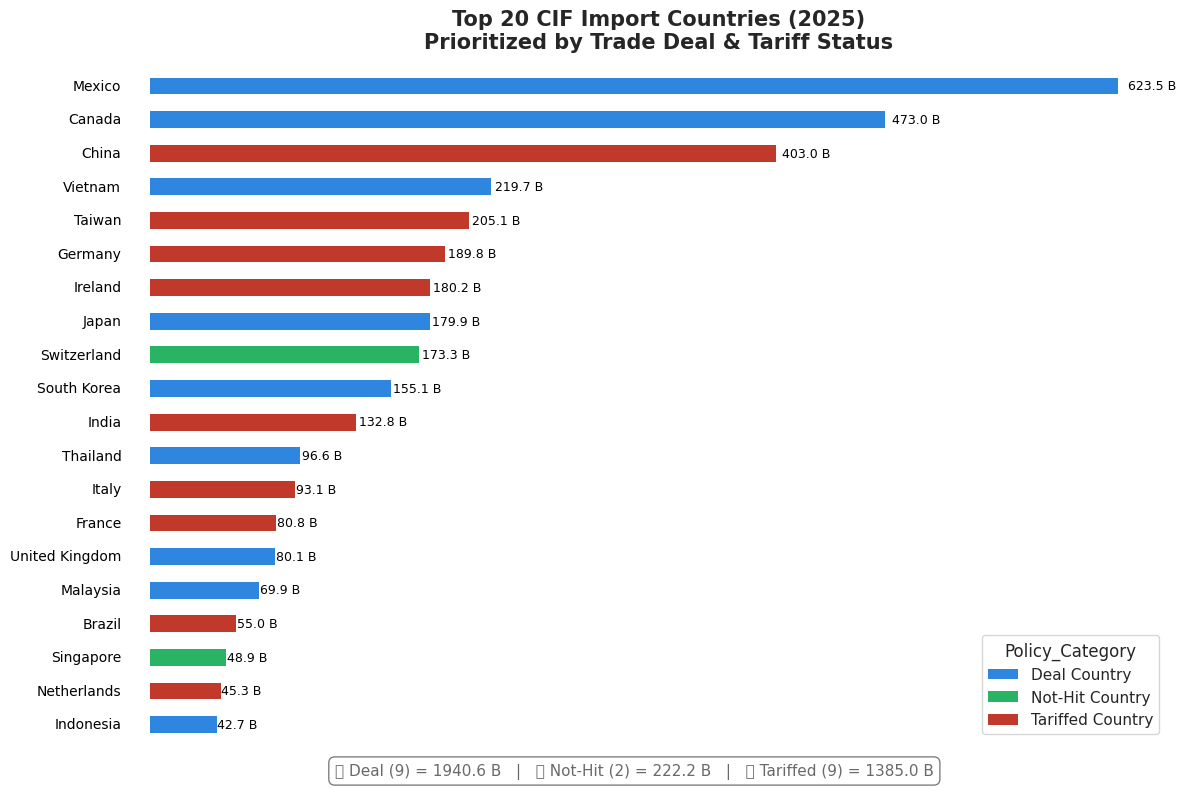

<Figure size 640x480 with 0 Axes>

In [ ]:
# Top 20 CIF Import Countries (2025)
# Includes Deal / Not-Hit / Tariffed Counts

# 1️⃣ Load dataset
file_path = "Country_CIF_Tariff_PctChange_2023_2025.xlsx"
df = pd.read_excel(file_path)

# 2️⃣ Clean column names
# Only clean non-year columns and convert year columns to numeric
non_year_cols = [c for c in df.columns if not re.match(r'\d{4}', str(c))]
df.columns = [c.strip().replace(" ", "_") if c in non_year_cols else c for c in df.columns]

if "Country" in df.columns:
    df.rename(columns={"Country": "country"}, inplace=True)
for y in [2023, 2024, 2025]:
    if y in df.columns:
        df[y] = pd.to_numeric(df[y], errors="coerce")

# Print columns to verify names after cleaning and conversion
print("Columns after cleaning and conversion:", df.columns.tolist())
print(df.head())

# 3️⃣ Label policy category
def label_policy(row):
    if row.get("Trump_Deal", 0) == 1:
        return "Deal Country"
    elif row.get("Not_Hit", 0) == 1:
        return "Not-Hit Country"
    else:
        return "Tariffed Country"

df["Policy_Category"] = df.apply(label_policy, axis=1)

# 4️⃣ Define colors and sort order
policy_colors = {
    "Deal Country": "#2E86DE",
    "Not-Hit Country": "#28B463",
    "Tariffed Country": "#C0392B"
}
policy_order = {"Deal Country": 1, "Not-Hit Country": 2, "Tariffed Country": 3}
df["Policy_Order"] = df["Policy_Category"].map(policy_order)

# 5️⃣ Top 20 by CIF 2025
if 2025 in df.columns:
    df_sorted = df.sort_values(2025, ascending=False).head(20) # Use integer 2025 if numeric column exists
    df_sorted = df_sorted.sort_values(by=["Policy_Order", 2025], ascending=[True, False]) # Use integer 2025
else:
    print("Error: Column '2025' not found in the DataFrame after processing.")
    df_sorted = pd.DataFrame() # Create empty DataFrame to avoid further errors

# 6️⃣ Prepare data for plotting (grouping)
if not df_sorted.empty:
    df_grouped = (df_sorted.groupby(["country", "Policy_Category"])[2025].sum().reset_index())

    pivot = df_grouped.pivot(index="country", columns="Policy_Category", values=2025).fillna(0) # Use integer 2025
    pivot["Total_CIF"] = pivot.sum(axis=1)
    pivot = pivot.sort_values("Total_CIF", ascending=True)

    # 7️⃣ Totals and counts for summary text
    # Ensure 2025 is used correctly
    total_deal = df_grouped.loc[df_grouped["Policy_Category"] == "Deal Country", 2025].sum() # Use integer 2025
    total_nothit = df_grouped.loc[df_grouped["Policy_Category"] == "Not-Hit Country", 2025].sum() # Use integer 2025
    total_tariff = df_grouped.loc[df_grouped["Policy_Category"] == "Tariffed Country", 2025].sum() # Use integer 2025

    # Calculate counts for summary text
    count_deal = df_grouped.loc[df_grouped["Policy_Category"] == "Deal Country"].shape[0]
    count_nothit = df_grouped.loc[df_grouped["Policy_Category"] == "Not-Hit Country"].shape[0]
    count_tariff = df_grouped.loc[df_grouped["Policy_Category"] == "Tariffed Country"].shape[0]


# ==========================================================
# 🌍 Minimalist Top 20 CIF Import Countries (2025)
# With Country Names + Compact Centered Legend
# ==========================================================
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- Minimalist styling ---
plt.rcParams.update({
    "axes.facecolor": "white",
    "axes.edgecolor": "none",
    "axes.grid": False,
    "font.size": 11,
    "axes.titleweight": "bold",
    "axes.labelcolor": "black",
    "figure.facecolor": "white"
})

# --- Verify columns to plot ---
plot_cols = [c for c in ["Deal Country", "Not-Hit Country", "Tariffed Country"] if c in pivot.columns]

if plot_cols:
    # Sort ascending for clean top-to-bottom order
    pivot_sorted = pivot.sort_values("Total_CIF", ascending=True)

    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # --- Plot stacked horizontal bars ---
    pivot_sorted[plot_cols].plot(
        kind="barh",
        stacked=True,
        color=[policy_colors[c] for c in plot_cols],
        ax=ax,
        edgecolor="none"
    )

    # --- Title ---
    ax.set_title(
        "Top 20 CIF Import Countries (2025)\nPrioritized by Trade Deal & Tariff Status",
        fontsize=15,
        pad=15
    )

    # --- Remove axis labels and ticks ---
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    # --- Add country names beside bars ---
    for i, (country, total) in enumerate(zip(pivot_sorted.index, pivot_sorted["Total_CIF"])):
        ax.text(
            -pivot_sorted["Total_CIF"].max() * 0.03,  # position left of bar
            i,
            country,
            va="center",
            ha="right",
            fontsize=10,
            color="black"
        )
        ax.text(
            total * 1.01,  # position right of bar
            i,
            f"{total/1e9:.1f} B",
            va="center",
            fontsize=9,
            color="black"
        )

    # --- Summary box (totals and counts) ---
    summary_text = (
        f"🟢 Deal ({count_deal}) = {total_deal/1e9:.1f} B   |   "
        f"🟡 Not-Hit ({count_nothit}) = {total_nothit/1e9:.1f} B   |   "
        f"🔴 Tariffed ({count_tariff}) = {total_tariff/1e9:.1f} B"
    )
    ax.text(
        pivot_sorted["Total_CIF"].max() * 0.5,
        -1.5,
        summary_text,
        fontsize=11,
        ha="center",
        color="dimgray",
        bbox=dict(facecolor="white", edgecolor="gray", boxstyle="round,pad=0.4"))

    plt.tight_layout()
    plt.show()

else:
    print("Skipping plot: required policy category columns not found.")
plt.savefig("Top 20 CIF Import Countries (2025)\nPrioritized by Trade Deal & Tariff Status.png", dpi=300, bbox_inches="tight")


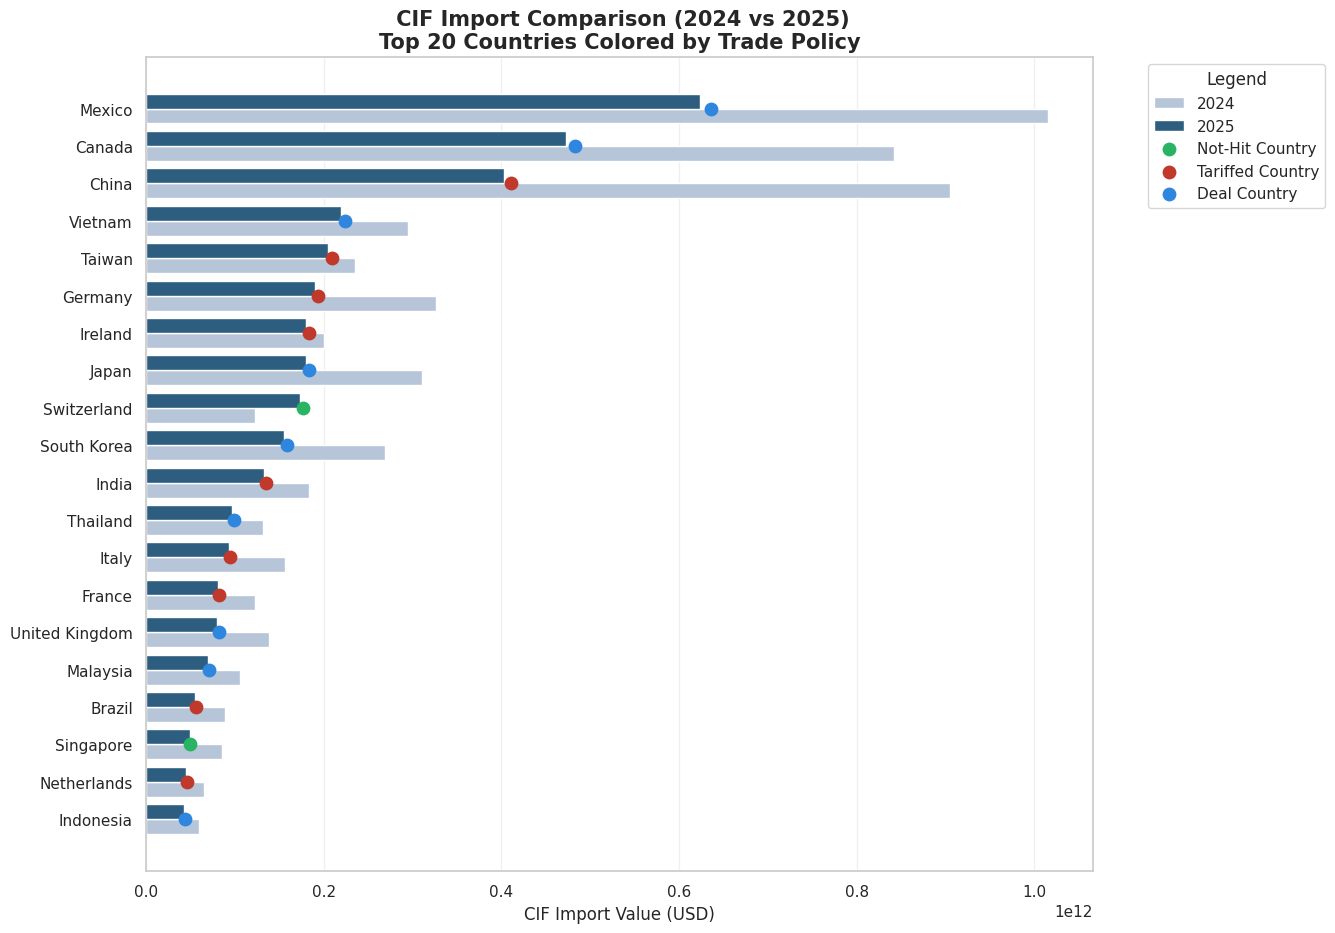

<Figure size 640x480 with 0 Axes>

In [ ]:
# CIF Import Comparison (2024 vs 2025)
# Top 20 Countries — Colored by Trump Tariff Policy

file_path = "Country_CIF_Tariff_PctChange_2023_2025.xlsx"
df = pd.read_excel(file_path)

# Clean column names
non_year_cols = [c for c in df.columns if not re.match(r'\d{4}', str(c))]
df.columns = [c.strip().replace(" ", "_") if c in non_year_cols else c for c in df.columns]
if "Country" in df.columns:
    df.rename(columns={"Country": "country"}, inplace=True)

# Convert year columns
for y in [2023, 2024, 2025]:
    if y in df.columns:
        df[y] = pd.to_numeric(df[y], errors="coerce")

#define policy labels
def label_policy(row):
    c = str(row.get("country", "")).strip().lower()
    trump_deal_countries = {"mexico", "canada"}  # override
    if c in trump_deal_countries or row.get("Trump_Deal", 0) == 1:
        return "Deal Country"
    elif row.get("Not_Hit", 0) == 1:
        return "Not-Hit Country"
    else:
        return "Tariffed Country"

df["Policy_Category"] = df.apply(label_policy, axis=1)

policy_colors = {
    "Deal Country": "#2E86DE",     # Blue
    "Not-Hit Country": "#28B463",  # Green
    "Tariffed Country": "#C0392B"  # Red
}

#  Get Top 20 Countries (based on 2025 total)
top20_2025 = df.sort_values(2025, ascending=False).head(20)["country"].tolist()
df_top = df[df["country"].isin(top20_2025)].copy()

# Melt for long format
df_melt = df_top.melt(
    id_vars=["country", "Policy_Category"],
    value_vars=[2024, 2025],
    var_name="Year",
    value_name="CIF_Value"
)

# Sort countries by 2025 values
order_2025 = (df_melt[df_melt["Year"] == 2025].sort_values("CIF_Value", ascending=True)["country"]
    .tolist())
df_melt["country"] = pd.Categorical(df_melt["country"], categories=order_2025, ordered=True)

# 4️⃣ Plot
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 10))

# Draw grouped bars — 2024 vs 2025
sns.barplot(
    data=df_melt,
    y="country",
    x="CIF_Value",
    hue="Year",
    dodge=True,
    palette=["#B0C4DE", "#1F618D"],  # light blue for 2024, dark blue for 2025
    ax=ax
)

# Overlay policy markers (circles on right side)
for i, row in df_melt[df_melt["Year"] == 2025].iterrows():
    y_pos = list(order_2025).index(row["country"])
    ax.scatter(
        row["CIF_Value"] * 1.02, y_pos,
        s=80,
        color=policy_colors.get(row["Policy_Category"], "gray"),
        label=row["Policy_Category"]
    )

ax.set_title(
    " CIF Import Comparison (2024 vs 2025)\nTop 20 Countries Colored by Trade Policy",
    fontsize=15, weight="bold"
)
ax.set_xlabel("CIF Import Value (USD)")
ax.set_ylabel("")
ax.invert_yaxis()

# Remove duplicate legend entries for markers
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title="Legend", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout(rect=[0, 0, 0.97, 0.95])
plt.show()
plt.savefig("CIF Import Comparison (2024 vs 2025)\nTop 20 Countries Colored by Trade Policy", dpi=300, bbox_inches="tight")


In [ ]:
print(f"""#After adding the variable, we can conclude that :
1. China has slower growth in 2025 because China is the only country, out of the 3 leading Countries, that has not made deal with Trump.
2. Out of biggest 20 countries, only two countries that in the list of not get hit by reciprocal tarif, which is Switzerland and Singapore. That also explains why Switzerland already showed increasing trend of import in 2025 eventhough the data only for August."""
#3. Germany, the number fourth biggest importer in 2024, showed decline trend in 2025, that also dont have made deal with Trump, similar to China)"""
)

#After adding the variable, we can conclude that :
1. China has slower growth in 2025 because China is the only country, out of the 3 leading Countries, that has not made deal with Trump.
2. Out of biggest 20 countries, only two countries that in the list of not get hit by reciprocal tarif, which is Switzerland and Singapore. That also explains why Switzerland already showed increasing trend of import in 2025 eventhough the data only for August.


## 🌍 CIF Import Analysis — 2024 vs 2025

### 📘 Executive Summary

The comparison between 2024 and 2025 CIF import values highlights how trade policies reshaped U.S. import dynamics. In 2024, import volumes reflected a stable, pre-tariff environment dominated by major partners such as China, Mexico, and Canada. By 2025, as reciprocal tariffs and selective trade deals took effect, the composition of top-importing countries began to shift: nations granted trade deals or exempt from tariffs generally maintained or increased their export values, while those hit by tariffs experienced noticeable declines.

The dual-panel visualization makes this contrast explicit-showing which partners benefited, which were insulated, and which faced contraction-providing a clear, data-driven view of the early economic impact of the Trump administration’s reciprocal-tariff policy.

---

### 📊 What the Charts Show

- **Left Chart (2024):** Displays the Top 20 countries by CIF import value before tariff policy changes. All bars use a single uniform color to represent the baseline import levels, creating a clear pre-policy benchmark.
- **Right Chart (2025):** Shows those same countries after the introduction of reciprocal tariffs. Each bar is color-coded by policy category:
  - 🔵 *Deal Country* — nations with formal trade deals or exemptions.
  - 🟢 *Not-Hit Country* — nations unaffected by reciprocal tariffs.
  - 🔴 *Tariffed Country* — nations that faced new or higher tariff rates.
- The **shared country order** between both charts allows direct side-by-side comparison, revealing which trading partners expanded, held steady, or declined under the new trade policy environment.

---

### 💡 Key Findings

- **Policy reshaped trade patterns:** The introduction of reciprocal tariffs in 2025 led to a visible redistribution of U.S. import sources, as shown by the divergence in bar lengths between 2024 and 2025.
- **Deal and Not-Hit countries held steady or expanded:** Nations with trade deals or unaffected by tariffs—often key U.S. partners such as Mexico, Canada, and parts of Southeast Asia—either maintained or increased their CIF import values.

Out of top 20 countries, only two countries that in the list of not get hit by reciprocal tarif, which is Switzerland and Singapore. That also explains why Switzerland already showed increasing trend of import in 2025 eventhough the data only for August."""

- **Tariffed countries faced contraction:** Major exporters subjected to tariffs, such as China and Germany, showed noticeable declines in CIF import totals relative to 2024.
- **Regional diversification emerged:** Some Asian and non-EU exporters rose in rank, suggesting early signs of supply-chain adjustment as importers sought tariff-neutral markets.
- **Policy signals mattered more than volume:** The presence or absence of tariff protection (color-coded in the chart) appears to correlate more strongly with import changes than sheer trade size—highlighting how policy expectations influenced trade behavior.

---

In [ ]:
import os
import zipfile
from google.colab import files

# Define the directory containing the generated figures (if any were saved there)
figures_dir = "figures"

# List of generated files to include in the zip
files_to_zip = [
    # Image files from plotting (adjust filenames if they were saved differently)
    os.path.join(figures_dir, "Total U.S. Imports (CIF Value) by Year.png"), # Assuming this was saved
    os.path.join(figures_dir, "Top 30 Countries: U.S. Import Trend (2023–2025).png"), # Assuming this was saved
    os.path.join(figures_dir, "Top 20 Importing Countries by Year (2023–2025).png"), # Assuming this was saved
    os.path.join(figures_dir, "Top 20 CIF Import Countries (Color by Tariff Category).png"), # Assuming this was saved
    os.path.join(figures_dir, "Top 20 CIF Import Countries (2025)\nPrioritized by Trade Deal & Tariff Status.png"), # Assuming this was saved
    os.path.join(figures_dir, "CIF Import Comparison (2024 vs 2025)\nTop 20 Countries Colored by Trade Policy.png"), # Assuming this was saved

    # HTML chart from Plotly
    "CIF_Import_Growth_Map.html",

    # Quarto report files
    "report.qmd",
    "report.html", # This will only be included if Quarto rendering was successful

    # Index file for website
    "index.html",

    # Data files (including country trend/analysis data which has regression inputs)
    "Country_CIF_Trend_Analysis.csv", # Contains data used in regression
    "Country_CIF_with_PctChange.xlsx", # Also contains country-level trends
    "CIF_top30_with_tariff_deal_not_hit.xlsx", # Contains tariff/deal info merged with top 30

]

# Define the name of the zip file
zip_filename = "analysis_outputs.zip"

# Create a zip file
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file_path in files_to_zip:
        # Handle files in the figures directory vs main directory
        if figures_dir in file_path:
             # If the directory 'figures' exists, write the file from there
            if os.path.exists(figures_dir):
                full_file_path = file_path
                arcname = os.path.join(os.path.basename(figures_dir), os.path.basename(file_path)) # Save with figures/ path inside zip
                if os.path.exists(full_file_path):
                     zipf.write(full_file_path, arcname)
                else:
                     print(f"Warning: File not found - {full_file_path}")
            else:
                print(f"Warning: Figures directory not found. Skipping {file_path}")
        else:
            # For files not in the figures directory, just write directly from the current directory
            if os.path.exists(file_path):
                zipf.write(file_path, os.path.basename(file_path))
            else:
                print(f"Warning: File not found - {file_path}")


print(f"\n✅ Created zip file: {zip_filename}")

# Provide a download link for the zip file
files.download(zip_filename)

Prioritized by Trade Deal & Tariff Status.png
Top 20 Countries Colored by Trade Policy.png

✅ Created zip file: analysis_outputs.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>